# Simulating Interest Rate Changes and Liability Hedging
### Implementing the Cox Ingersoll Ross Model for interest rates

We're going to simulate changes in interest rates using the Cox-Ingersoll-Ross model, usually just called the CIR model. It is very similar to what we have already done for generating random stock prices. Instead of a Geometric Brownian Motion, the mean reversion model features parameters to control the speed of mean reversion as well as the long term average rate.

$$ dr_{t}=a(b-r_{t})\,dt+\sigma {\sqrt  {r_{t}}}\,dW_{t} $$

where $a$ is the speed of mean reversion and $b$ is the long term mean rate and $\sigma$ is the volatility parameter.

This can be read as describing the change in interest at any point of time as a multiple of the distance of the current rate from it's long term mean plus a random value that depends on the volatility parameter.

Thus, we can start at some rate $r_0$ and generate a sequence of rates over time using the change in rate defined by the stochastic differential equation above. If we eliminate the ${\sqrt  {r_{t}}}$ term we get the simpler Vasicek model, but the CIR model eliminates the possibility of negative interest rates by shutting down the volatility term as interest rates approach zero. 

### Short Rate vs Annualized Rate

One final piece of math we'll need is that the interest rate being described here is the "instantaneous" or "short rate" ... we will often want to think about interest rates as annualized rates, which means that the instantaneous rate needs to be compounded into an annual rate as follows:

$$ 1 + r_{annual} = e^{r_{inst}} $$

Think about if the interest is compuonded 1x a year, 2x a year, 4x, etc

In general, if we compound every 1/N of a year (i.e. N times a year) we get:

$$\left(1+\frac{r}{N}\right)^N$$


In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import edhec_risk_kit as erk
import ipywidgets as widgets
from IPython.display import display

In [2]:
def inst_to_ann(r):
    """
    Convert an instantaneous interest rate to an annual interest rate
    """
    return np.expm1(r)

def ann_to_inst(r):
    """
    Convert an instantaneous interest rate to an annual interest rate
    """
    return np.log1p(r)

def cir(n_years = 10, n_scenarios=1, a=0.05, b=0.03, sigma=0.05, steps_per_year=12, r_0=None):
    """
    Generate random interest rate evolution over time using the CIR model
    b and r_0 are assumed to be the annualized rates, not the short rate
    and the returned values are the annualized rates as well
    """
    if r_0 is None: r_0 = b 
    r_0 = ann_to_inst(r_0)
    dt = 1/steps_per_year
    num_steps = int(n_years*steps_per_year) + 1 # because n_years might be a float
    
    shock = np.random.normal(0, scale=np.sqrt(dt), size=(num_steps, n_scenarios))
    rates = np.empty_like(shock)
    rates[0] = r_0
    for step in range(1, num_steps):
        r_t = rates[step-1]
        d_r_t = a*(b-r_t)*dt + sigma*np.sqrt(r_t)*shock[step]
        rates[step] = abs(r_t + d_r_t) # just in case of roundoff errors going negative
        
    return pd.DataFrame(data=inst_to_ann(rates), index=range(num_steps))

## Generating the random price evolution of a Zero-Coupon Bond

The model can also be used to generate the movement of bond prices for a zero coupon bond that are implied by the generated interest rate, using the following equations:

$$P(t,T)=A(t,T)e^{-B(t,T)r_{t}}\!$$

where

$$ A(t,T)=\left({\frac  {2h e^{(a+h)\tau/2}}{2h+(a+h)(e^{\tau h}-1)}}\right)^{{2ab/\sigma ^{2}}} $$
and
$$ B(t,T)={\frac  {2(e^{\tau h}-1)}{2h+(a+h)(e^{\tau h}-1)}} $$
and
$$ h={\sqrt  {a^{2}+2\sigma ^{2}}} $$
and
$$ \tau = T-t $$


In [3]:
import math
def cir(n_years = 10, n_scenarios=1, a=0.05, b=0.03, sigma=0.05, steps_per_year=12, r_0=None):
    """
    Generate random interest rate evolution over time using the CIR model
    b and r_0 are assumed to be the annualized rates, not the short rate
    and the returned values are the annualized rates as well
    """
    if r_0 is None: r_0 = b 
    r_0 = ann_to_inst(r_0)
    dt = 1/steps_per_year
    num_steps = int(n_years*steps_per_year) + 1 # because n_years might be a float
    
    shock = np.random.normal(0, scale=np.sqrt(dt), size=(num_steps, n_scenarios))
    rates = np.empty_like(shock)
    rates[0] = r_0

    ## For Price Generation
    h = math.sqrt(a**2 + 2*sigma**2)
    prices = np.empty_like(shock)
    ####

    def price(ttm, r):
        _A = ((2*h*math.exp((h+a)*ttm/2))/(2*h+(h+a)*(math.exp(h*ttm)-1)))**(2*a*b/sigma**2)
        _B = (2*(math.exp(h*ttm)-1))/(2*h + (h+a)*(math.exp(h*ttm)-1))
        _P = _A*np.exp(-_B*r)
        return _P
    prices[0] = price(n_years, r_0)
    ####
    
    for step in range(1, num_steps):
        r_t = rates[step-1]
        d_r_t = a*(b-r_t)*dt + sigma*np.sqrt(r_t)*shock[step]
        rates[step] = abs(r_t + d_r_t)
        # generate prices at time t as well ...
        prices[step] = price(n_years-step*dt, rates[step])

    rates = pd.DataFrame(data=inst_to_ann(rates), index=range(num_steps))
    ### for prices
    prices = pd.DataFrame(data=prices, index=range(num_steps))
    ###
    return rates, prices


In [4]:
def show_cir_prices(r_0=0.03, a=0.5, b=0.03, sigma=0.05, n_scenarios=5):
    cir(r_0=r_0, a=a, b=b, sigma=sigma, n_scenarios=n_scenarios)[1].plot(legend=False, figsize=(12,5))

controls = widgets.interactive(show_cir_prices,
                              r_0 = (0, .15, .01),
                              a = (0, 1, .1),
                               b = (0, .15, .01),
                               sigma= (0, .1, .01),
                               n_scenarios = (1, 100))
display(controls)

interactive(children=(FloatSlider(value=0.03, description='r_0', max=0.15, step=0.01), FloatSlider(value=0.5, …

In [5]:
#notice how the price of the bond ALWAYS converges to 1

In [13]:
a_0 = .75
rates, bond_prices = cir(r_0 = .03, b = .03, n_scenarios = 10)
liabilities = bond_prices #liability prices can be treated like a zero-coupon bond

zcbond_10 = pd.Series(data = [1], index = [1])
zc_0 = erk.pv(zcbond_10, r = .03)
n_bonds = a_0 / zc_0

av_zc_bonds = n_bonds*bond_prices
av_cash = a_0*(rates/12 + 1).cumprod()

<AxesSubplot:>

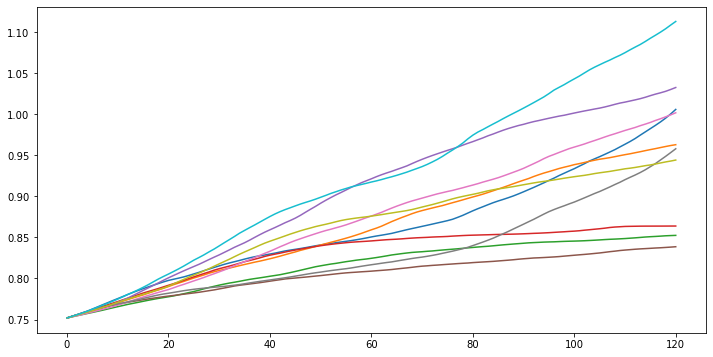

In [15]:
av_cash.plot(legend=False, figsize=(12,6))

<AxesSubplot:>

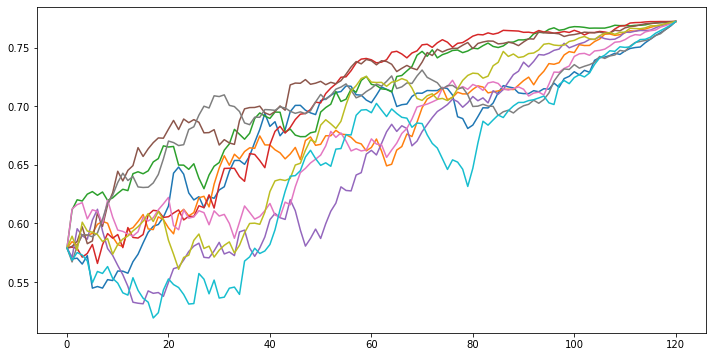

In [17]:
av_zc_bonds.plot(legend=False, figsize=(12,6))

The evolution of your assets over time. 

If you put your money (.75) in cash, and you want to match your liability 10 years from now at 1M
* You might make it, you might not

If you put it into zero coupon bonds, it LOOK riskier, but you actually always end up at 1

<AxesSubplot:title={'center':'Returns of funding ratio with cash'}>

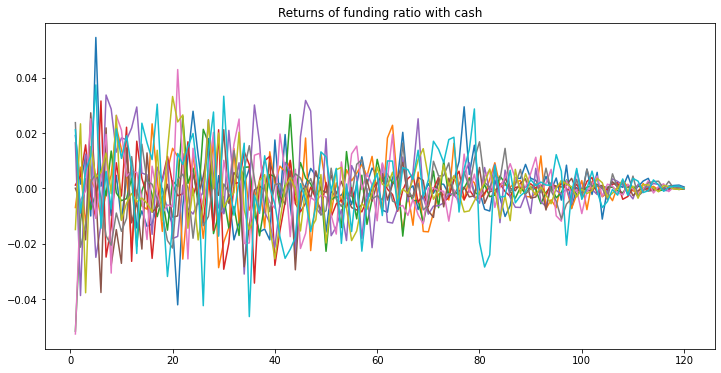

In [19]:
(av_cash/liabilities).pct_change().plot(title='Returns of funding ratio with cash', legend=False, figsize=(12,6))

<AxesSubplot:title={'center':'Returns of funding ratio with Coupons'}>

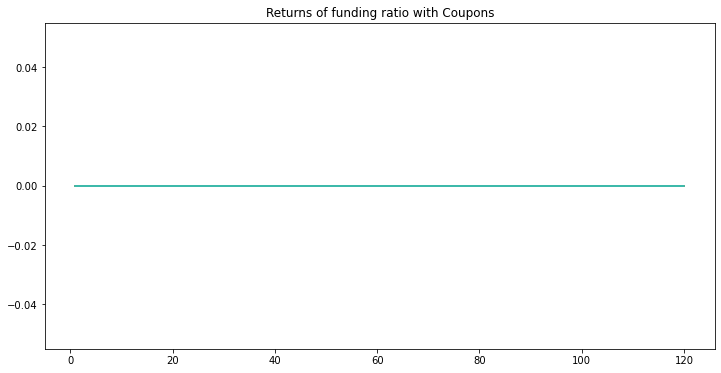

In [26]:
(av_zc_bonds/liabilities).pct_change().round(3).plot(title='Returns of funding ratio with Coupons', legend=False, figsize=(12,6))

In [56]:
a_0 = .75
rates, bond_prices = cir(n_scenarios=10000, r_0 = .03, b=.03)
liabilities = bond_prices
zc_0 = erk.pv(zcbond_10, .03)

n_bonds = a_0 / zc_0
av_zc_bonds = n_bonds * bond_prices
av_cash = a_0*(rates/12+1).cumprod()

In [57]:
tfr_cash = av_cash.iloc[-1]/liabilities.iloc[-1]
tfr_zc_bonds = av_zc_bonds.iloc[-1] / liabilities.iloc[-1]

<AxesSubplot:label='39e6a1ca-b1cd-42ef-b177-9259539086fd'>

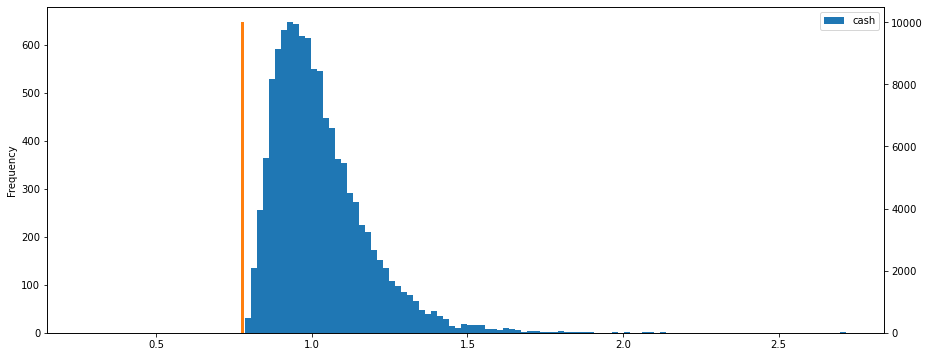

In [58]:
ax = tfr_cash.plot.hist(label = 'cash', figsize = (15,6), bins = 100, legend = True)
tfr_zc_bonds.plot.hist(ax=ax, label = 'zero coupon', figsize = (15,6), bins = 100, secondary_y=True)

In [59]:
#something is wrong here, the orange line should be at 1

0.7725

In [65]:
zc_0

0.970873786407767

In [48]:
zc_0

0.970873786407767

In [49]:
n_bonds

0.7725